In [2]:
import itk
import vtk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

# 1) Données

In [3]:
PixelType = itk.ctype("double")
fixed_image = itk.imread("Data/case6_gre1.nrrd", PixelType)
moving_image = itk.imread("Data/case6_gre2.nrrd", PixelType)

# 2) Recalage d'images

In [4]:
dimension = fixed_image.GetImageDimension()
FixedImageType = type(fixed_image)
MovingImageType = type(moving_image)
TransformType = itk.TranslationTransform[PixelType , dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(4)
optimizer.SetMinimumStepLength(0.001)
optimizer.SetNumberOfIterations(200)

metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()

registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType, ].New(FixedImage=fixed_image, MovingImage=moving_image, Metric=metric,
                                                     Optimizer=optimizer, InitialTransform=initialTransform, )

moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
initial_parameters[0] = 0
initial_parameters[1] = 0
initial_parameters[2] = 0
moving_initial_transform.SetParameters(initial_parameters)

scale_parameters = moving_initial_transform.GetParameters()
scale_parameters[0] = 1000
scale_parameters[1] = 1
scale_parameters[2] = 1
optimizer.SetScales(scale_parameters)

identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)
registration.SetNumberOfLevels(1)

registration.Update()

In [9]:
transform = registration.GetTransform()
CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
output_composite_transform = CompositeTransformType.New()
output_composite_transform.AddTransform(moving_initial_transform)
output_composite_transform.AddTransform(registration.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=transform, UseReferenceImage=True,
                                            ReferenceImage=fixed_image)
resampler.SetDefaultPixelValue(100)
resampler.Update()
resampled = resampler.GetOutput()

In [10]:
OutputImageType = FixedImageType
caster = itk.CastImageFilter[FixedImageType, OutputImageType].New(resampled)
caster.Update()
casted = caster.GetOutput()

# 3) Segmentation des tumeurs

In [115]:
seedX = 98
seedY = 82
lower = 280
upper = 1400
slice_index = 79
dimension = 3

# Add a bit of noise to find close tumors
smoother = itk.GradientAnisotropicDiffusionImageFilter.New(
    Input=casted,
    NumberOfIterations=20,
    TimeStep=0.04,
    ConductanceParameter=3
)
smoother.Update()

# Segment the image
connected_threshold = itk.ConnectedThresholdImageFilter.New(smoother.GetOutput()) #scan2
connected_threshold.SetReplaceValue(1374)
connected_threshold.SetLower(lower)
connected_threshold.SetUpper(upper)
connected_threshold.SetSeed((seedX, seedY, slice_index))
connected_threshold.Update()

# Convert the pixel type to unsigned char (UC)
in_type = type(connected_threshold.GetOutput())
out_type = itk.Image[itk.UC, dimension]
cast_filter = itk.CastImageFilter[in_type, out_type].New()
cast_filter.SetInput(connected_threshold.GetOutput())
cast_filter.Update()
segmented_image = cast_filter.GetOutput()

# Convert the segmented image to a NumPy array for visualization
segmented_np = itk.array_view_from_image(segmented_image)

# Rescale the intensity values for easier visualization
rescaler = itk.RescaleIntensityImageFilter[out_type, out_type].New()
rescaler.SetInput(segmented_image)
rescaler.SetOutputMinimum(0)
rescaler.SetOutputMaximum(255)
rescaler.Update()
segmented_image_rescaled = rescaler.GetOutput()
segmented_np_rescaled = itk.array_view_from_image(segmented_image_rescaled)

# Save the image
itk.imwrite(segmented_image_rescaled, 'Data/segmented_image.nrrd')

# 4) Analyse et visualisation des changements

Vous pouvez choisir la slice a afficher en modifiant la variable `index`. <br> Le scan de base est a gauche, la segmentation est a droite.

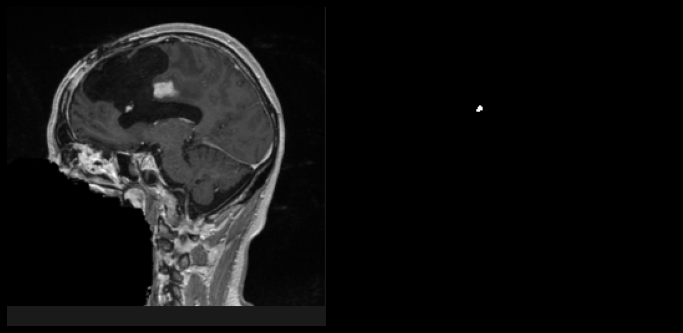

In [117]:
index = 79

fig, axs = plt.subplots(1, 2, figsize=(12, 10))
axs[0].imshow(casted[index], cmap='gray')
axs[0].axis('off')

axs[1].imshow(segmented_image_rescaled[index], cmap='gray')
axs[1].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()